In [1]:
#Leemos los datos y los unimos en 1 dataframe
import pandas as pd
import pandasql as ps
import numpy as np
df_es= pd.read_parquet("rawData_preprocessed_test_DA_ES.parquet",engine='auto')
df_es['Country'] = 'Spain'
df_gb= pd.read_parquet("rawData_preprocessed_test_DA_GB.parquet",engine='auto')
df_gb['Country'] = 'Great Britain'
df_fr= pd.read_parquet("rawData_preprocessed_test_DA_FR.parquet",engine='auto')
df_fr['Country'] = 'France'
df_br= pd.read_parquet("rawData_preprocessed_test_DA_BR.parquet",engine='auto')
df_br['Country'] = 'Brasil'
df = pd.concat([df_es,df_gb,df_fr,df_br])
df['link'] = df.index
#df.groupby(['pageBrandsafe']).size()

# Falta clean_text

words = df["text"].tolist()
list_of_lists =[]
for i in words: list_of_lists.append(i.split(" "))
df["list_clean_text"] = list_of_lists 
df["clean_text_aux"] = [' '.join(x) for x in list_of_lists]

In [2]:
#df_prueba = df[['title','body','text','clean_text','list_clean_text','clean_text_aux']].sample(10)

# 1. Descriptive questions

### 1.1 Which is the best country in terms of brand safety?

In [3]:
import cufflinks as cf
from IPython.display import display,HTML
cf.set_config_file(sharing='public',theme='henanigans',offline=True)
aux1_1 = pd.crosstab(df['Country'], df['pageBrandsafe']).apply(lambda r: r/r.sum()*100, axis=1)
aux1_1.iplot(kind='bar', color=['red','lightgreen','lightgrey'],
        xTitle='Country', yTitle='brandSafe over total articles',
        title= 'Percentage of brandSafe articles by Country')


###### 💡Best country in terms of safety is Spain, where 78% of the articles are suitable for a brand (+2p.p. above Great Britain -the second brand safest country- and +11p.p. above Brasil -the less safe brand country-)

### 1.2 Compare the different categories per country in terms of supply, total ads displayed and ads displayed with respect to javascript clients loaded

In [4]:
aux_1_2_0 = pd.crosstab(df['pageCategory'], df['Country']).apply(lambda x: 100 * x / float(x.sum()) ).T
aux_1_2_0.iplot(kind='bar', color=['deepskyblue','springgreen','magenta','yellow'],
        xTitle='Country', yTitle='Percentage over total',
        title= 'Most frequent categories of articles by Country')

##### 💡Vehicles and **Tech** are  most frequent categories, representing more than 60% of total articles. In Brasil and Spain, Vehicles is the dominant category (43% and 47% respectively). In France and Great Britain, Tech is the dominant category (37% and 58% respectively), France with more interest in Style than others and Great Britan with less interest in Environment and Style than others. More than half of articles in Great Britain are about Technology

In [5]:
aux_1_2_1 = df.groupby(['Country', 'pageCategory']).agg({'ClientLoad':'sum'})
aux_1_2_1 = pd.pivot_table(aux_1_2_1, values='ClientLoad',index=['Country'],columns='pageCategory')
aux_1_2_1.iplot(kind='bar', color=['deepskyblue','springgreen','magenta','yellow'],
        xTitle='Country', yTitle='Supply',
        title= 'Categories per country in terms of Supply')

##### 💡The Supply in Environment is low in general. Altough, in France, the top supply category is Style, with Vehicles and Tech having also importance. In Great Britain, the distribution is similar to France but Style has the lowest volume of supply. Spain has a lot of Supply in general, focused in Style (20M) which almost doubles Vehicles supply (11M)

In [6]:
aux_1_2_2 = df.groupby(['Country', 'pageCategory']).agg({'ClientAdImpression':'sum'})
aux_1_2_2 = pd.pivot_table(aux_1_2_2, values='ClientAdImpression',index=['Country'],columns='pageCategory')
aux_1_2_2.iplot(kind='bar', color=['deepskyblue','springgreen','magenta','yellow'],
        xTitle='Country', yTitle='Ads Displayed',
        title= 'Categories per country in terms of Total Ad Displayed')

##### 💡Vehicles is the category where more ads are displayed, specially in Brasil and Spain, where the volume doubles second most displayed category. In France and Great Britan, as we saw before, Tech is also way important. In Great Britan, Environment doubles Style and in France Tech and Style are more relevant (Tech is same as Vehicles).

In [7]:
aux1 = df.groupby(['Country', 'pageCategory']).agg({'ClientAdRequest':'sum'})
aux2 = df.groupby(['Country', 'pageCategory']).agg({'ClientAdImpression':'sum'})
aux_1_2_3 = aux1.merge(aux2, on=['Country','pageCategory'], how='left', indicator=False)
aux_1_2_3['Pct'] = 100*(aux_1_2_3['ClientAdImpression']/aux_1_2_3['ClientAdRequest'])
aux_1_2_3 = aux_1_2_3['Pct'].unstack(level=1)
aux_1_2_3.iplot(kind='bar', color=['deepskyblue','springgreen','magenta','yellow'],
    xTitle='Country', yTitle='Pct AdDisplayed/AdRequest',
    title= 'Categories per country in terms of Ad Displayed / Ad Request')

##### 💡The best display ratios are in Brasil and Spain. In Brasil, except Tech which is below 50%, the rest of categories are above 60%. There is an inminent problem in terms of display ratio in Great Britain with Style and Fashion (<20% of Ads Requested are Displayed)

# 2. Real use cases

### 2.1 Monetization of non brand safe inventory is practically null. We build our bransafety algorithm based on language and category, knowing that, where would you suggest we focus the efforts of our data science team in order to improve monetization?

##### 💡First of all, I would suggest to center the focus in ratios such as Ad Displayed / Ad Request to show the clients in which categories the return is being more efficient, deppending on the country. 


##### 💡In second place, brandSafe articles represent 75% of total inventory. So, first of all, I would suggest to test again some articles that are cataloged as non brand safe inventory. Some articles of that 25% non safe inventory (which 97% are labeled as "false" and rest as "unknown") seems to be safe for the brands. Some examples labeled as "false" to take in consideration: 

In [8]:
no_monetization = df.loc[df['pageBrandsafe'] != 'true'][['pageBrandsafe','text','pageCategory','link']]
no_monetization = no_monetization.loc[no_monetization['text'].str.contains("Donostia", case=False)]
no_monetization = no_monetization.loc[~no_monetization['link'].str.contains("coronavirus", case=False)]
no_monetization = no_monetization.loc[~no_monetization['link'].str.contains("fallece", case=False)]
no_monetization

,pageBrandsafe,text,pageCategory,link
donostitik.com/y-si-hubiera-un-frankenstein-botanical-park-en-donostia/,false,¿Y si hubiera un Frankenstein Botanical Park e...,environment,donostitik.com/y-si-hubiera-un-frankenstein-bo...
noticiasdegipuzkoa.eus/deportes/otros-deportes/2021/09/09/lopez-volver-astana/1139374.html,false,Ciclismo: López podría volver al Astana Donost...,autos-and-vehicles,noticiasdegipuzkoa.eus/deportes/otros-deportes...
noticiasdegipuzkoa.eus/deportes/ciclismo/2021/09/02/marino-lagos/1137810.html,false,Miguel Usabiaga: Marino Lejarreta y los Lagos ...,autos-and-vehicles,noticiasdegipuzkoa.eus/deportes/ciclismo/2021/...
noticiasdegipuzkoa.eus/deportes/otros-deportes/2021/09/07/ciclista/1138830.html,false,"A rueda, por Miguel Usabiaga: el ciclista de l...",autos-and-vehicles,noticiasdegipuzkoa.eus/deportes/otros-deportes...
deia.eus/bizkaia/bilbao/2021/08/30/escape-room-bolsillo-salir-bilbao/1146922.html,false,'Escape room' de bolsillo sin salir de Bilbao ...,technology,deia.eus/bizkaia/bilbao/2021/08/30/escape-room...
noticiasdegipuzkoa.eus/gipuzkoa/oarsoaldea/2021/09/04/pasaia--juanita-larando-vuelve/1138371.html,false,Pasaia 'Juanita Larando' vuelve a surcar los m...,autos-and-vehicles,noticiasdegipuzkoa.eus/gipuzkoa/oarsoaldea/202...



### 2.1 Which is the content around Audi? And Toyota’s? Try to explain the difference and similarities between them in terms of content.

In [9]:
from collections import Counter
from nltk.corpus import stopwords as sw
from nltk.tokenize import word_tokenize
stopwords = sw.words('english') + sw.words('french') + sw.words('spanish') + sw.words('portuguese')
words = df["clean_text_aux"].tolist()


<Figure size 432x288 with 0 Axes>

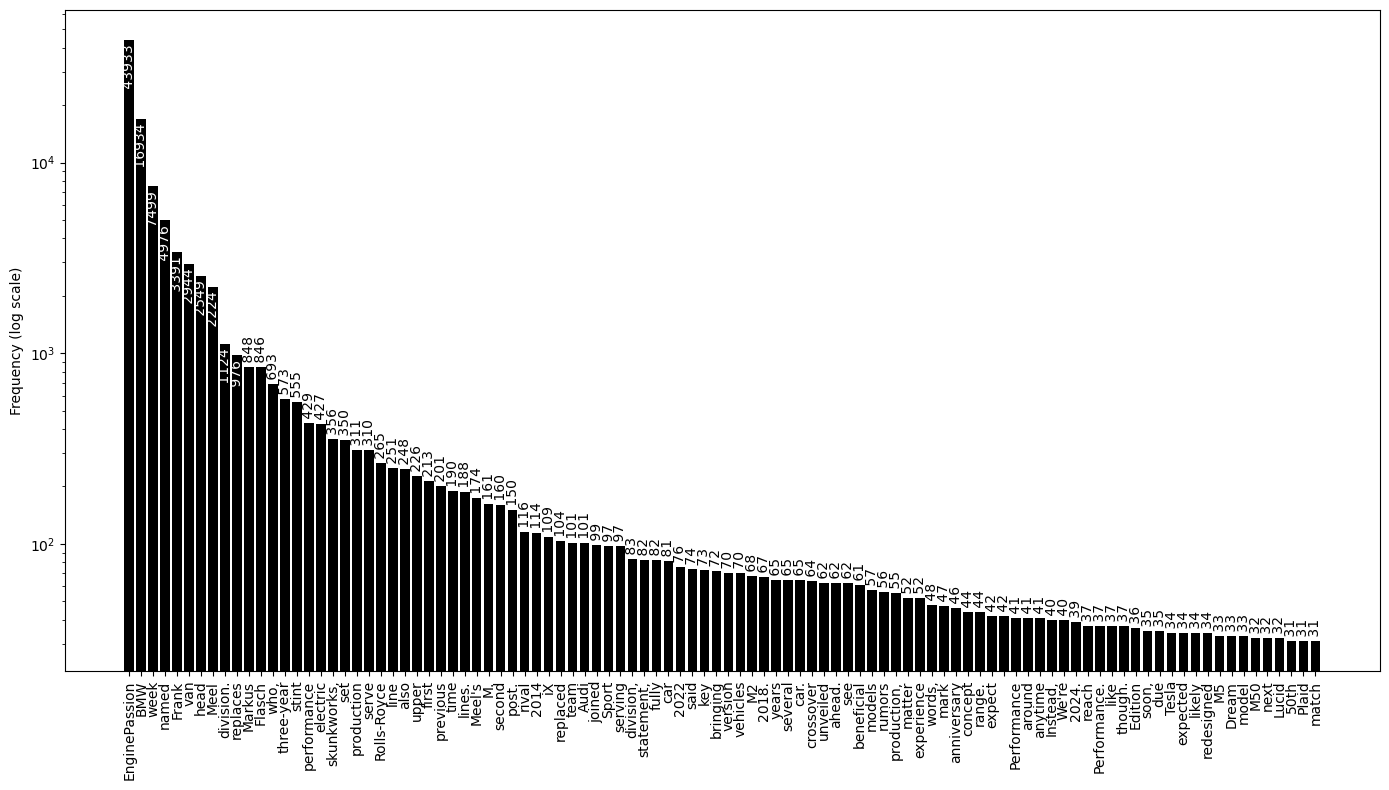

<Figure size 432x288 with 0 Axes>

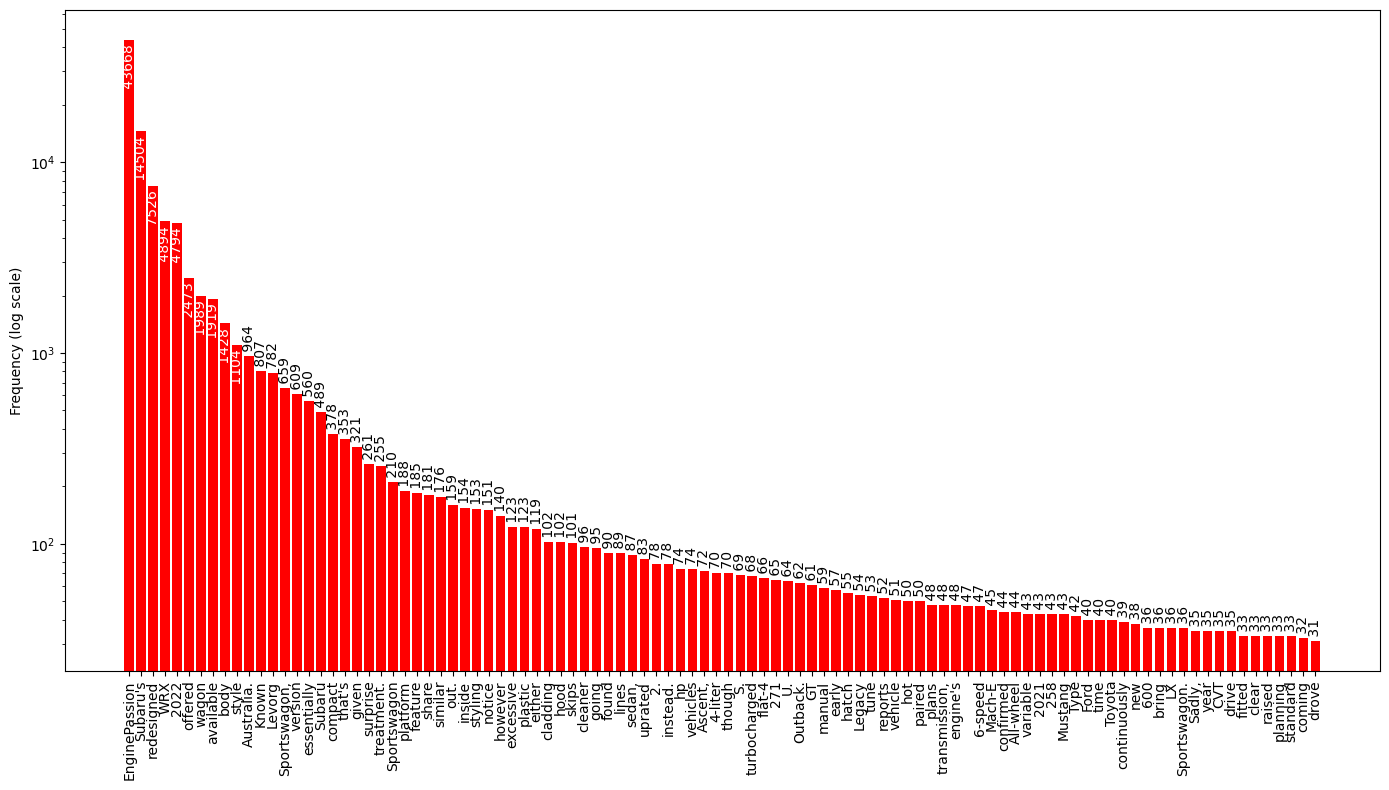

In [10]:
df_audi = df[df.text.str.contains(r"\b(?:audi)\b", case=False)]
df_audi = df_audi.loc[df_audi['Country'] == "Spain"]

words_audi = df_audi["clean_text_aux"].tolist()
list_of_lists_audi =[]
for i in words_audi: list_of_lists_audi.append(i.split(" "))
words_audi = [item for sublist in list_of_lists_audi for item in sublist]


list_of_lists =[]
for i in words_audi: list_of_lists.append(i.split(" "))
flat_list = [item for sublist in list_of_lists for item in sublist]
list_words = [w for w in flat_list if not w.lower() in stopwords]


#Counter(list_words).most_common(100)
from matplotlib import pyplot as plt
indices = np.random.zipf(1.6, size=100000).astype(int) % len(list_words)
articles = np.array(list_words)[indices]
tf = Counter(articles)
plt.figure().suptitle('AUDI 100 MOST COMMON WORDS')
plt.figure(figsize=(14, 8), dpi=100)

y = [count for tag, count in tf.most_common(100)]
x = [tag for tag, count in tf.most_common(100)]
plt.bar(x, y, color='black')
plt.ylabel("Frequency (log scale)")
plt.yscale('log') # optionally set a log scale for the y-axis
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(100)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')

plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()


#df_toyota = df.query('clean_text_aux.str.contains("toyota")', engine='python')
df_toyota = df[df.text.str.contains(r"\b(?:toyota)\b", case=False)]
df_toyota = df_toyota.loc[df_toyota['Country'] == "Spain"]

words_toyota = df_toyota["clean_text_aux"].tolist()
list_of_lists_toyota =[]
for i in words_toyota: list_of_lists_toyota.append(i.split(" "))
words_toyota = [item for sublist in list_of_lists_toyota for item in sublist]
list_of_lists =[]
for i in words_toyota: list_of_lists.append(i.split(" "))
flat_list = [item for sublist in list_of_lists for item in sublist]
list_words = [w for w in flat_list if not w.lower() in stopwords]
#Counter(list_words).most_common(100)
from matplotlib import pyplot as plt
indices = np.random.zipf(1.6, size=100000).astype(int) % len(list_words)
articles = np.array(list_words)[indices]
tf = Counter(articles)
plt.figure().suptitle('TOYOTA 50 MOST COMMON WORDS')
plt.figure(figsize=(14, 8), dpi=100)
y = [count for tag, count in tf.most_common(100)]
x = [tag for tag, count in tf.most_common(100)]
plt.bar(x, y, color='red')
plt.ylabel("Frequency (log scale)")
plt.yscale('log') # optionally set a log scale for the y-axis
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(100)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')

plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

##### 💡Spain Network:
The most common words in Audi are: 
- performance
- electric
- Rolls-Royce
- upper
- time
- team
- sport
- Audi
- beneficial
- concept
- experience
- beneficial
- dream
- lucid
- redesigned
- Tesla
- ...
    ###### 💡AUDI SPAIN: EXPERIENCE AND LIFESTYLE // ROLLS-ROYCE AND TESLA
    
    
The most common words in Toyota are: 
- redesigned
- available
- Subaru
- body
- compact
- treatment
- style
- platform
- feature
- styling
- plastic
- sedan
- cleaner
- engine's
- transmission
- turbocharged
- hatch
- development
- badge
- Mustang
- Lexus
- suspension
- ...

    ###### 💡TOYOTA SPAIN: FEATURES AND CHARACTERISTICS // SUBARU, MUSTANG AND LEXUS



<Figure size 432x288 with 0 Axes>

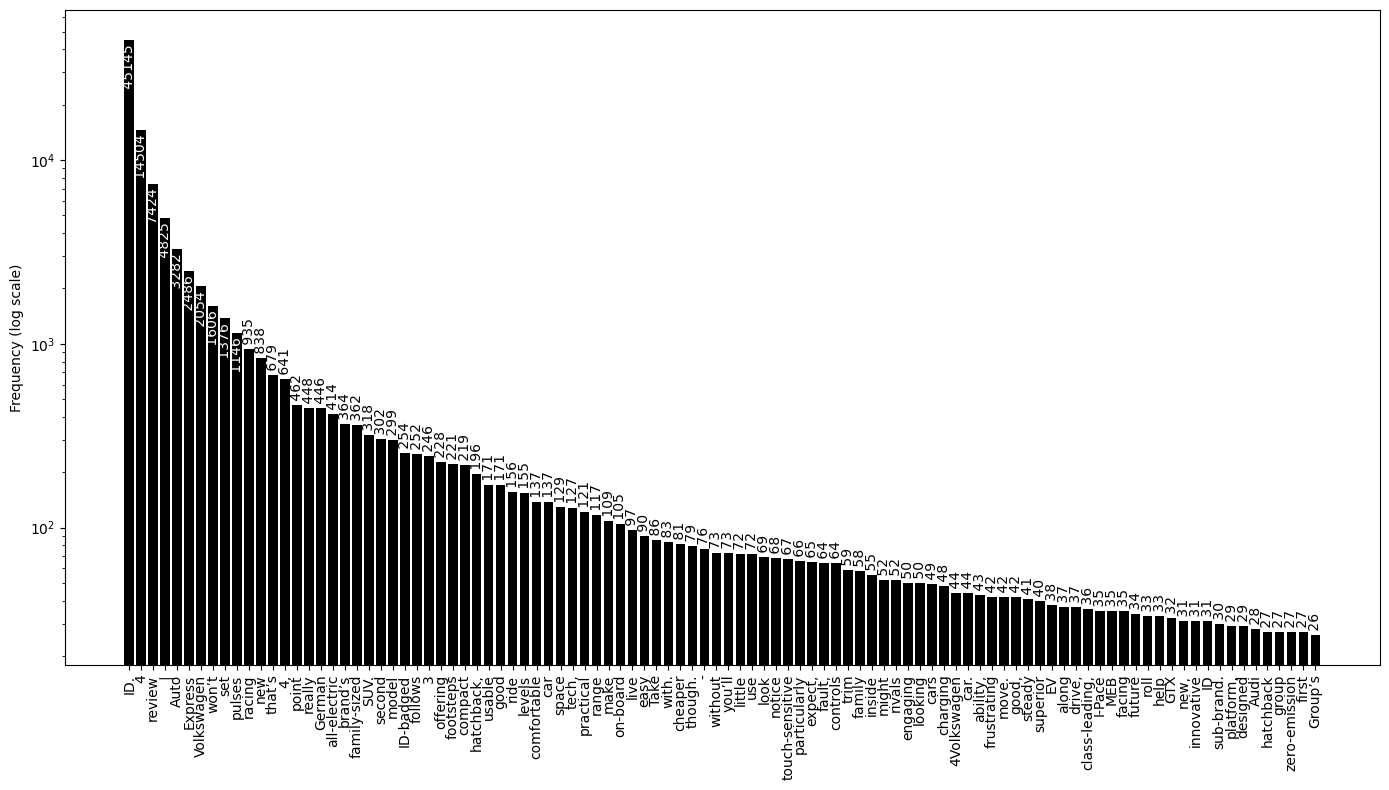

<Figure size 432x288 with 0 Axes>

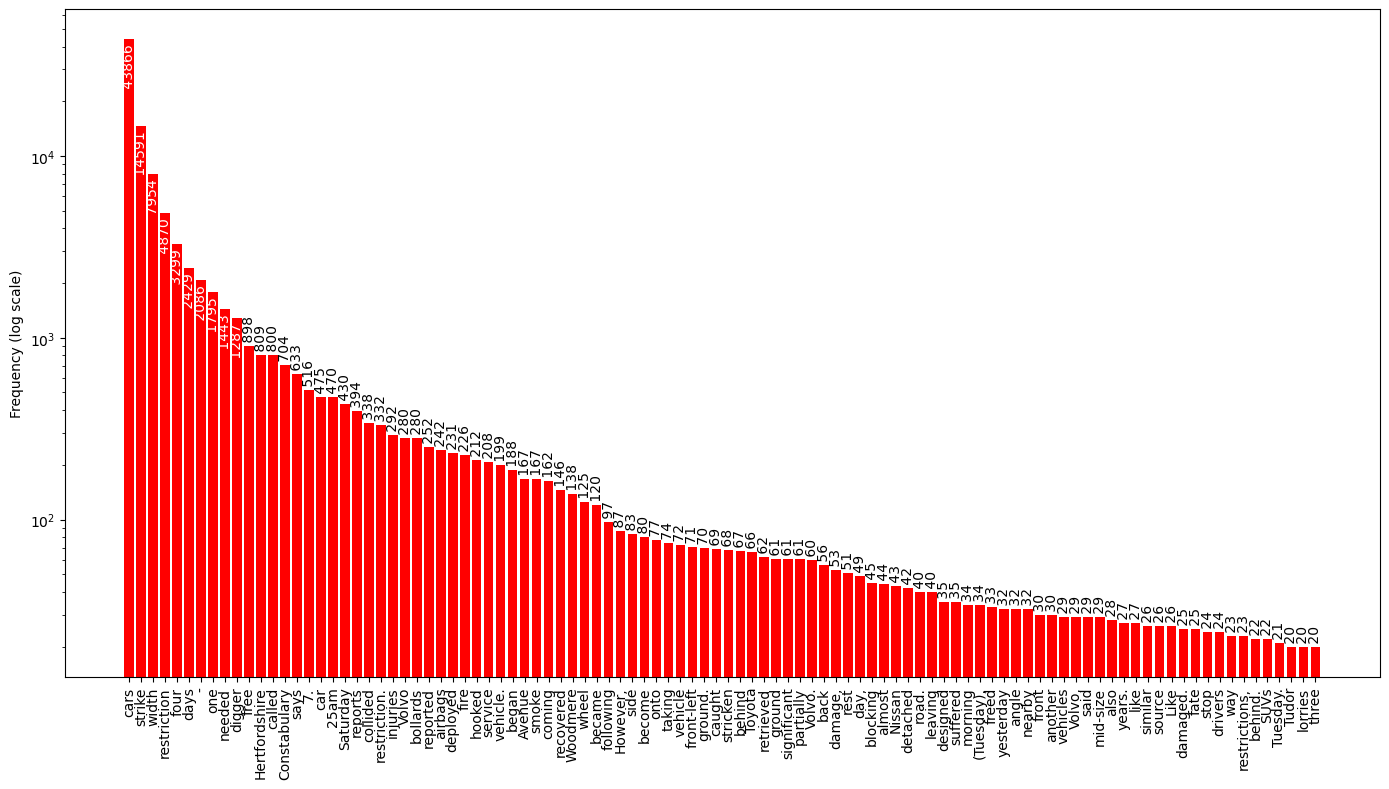

In [11]:
df_audi = df[df.text.str.contains(r"\b(?:audi)\b", case=False)]
df_audi = df_audi.loc[df_audi['Country'] == "Great Britain"]

words_audi = df_audi["clean_text_aux"].tolist()
list_of_lists_audi =[]
for i in words_audi: list_of_lists_audi.append(i.split(" "))
words_audi = [item for sublist in list_of_lists_audi for item in sublist]
list_of_lists =[]
for i in words_audi: list_of_lists.append(i.split(" "))
flat_list = [item for sublist in list_of_lists for item in sublist]
list_words = [w for w in flat_list if not w.lower() in stopwords]


#Counter(list_words).most_common(100)
from matplotlib import pyplot as plt
indices = np.random.zipf(1.6, size=100000).astype(int) % len(list_words)
articles = np.array(list_words)[indices]
tf = Counter(articles)
plt.figure().suptitle('AUDI 100 MOST COMMON WORDS')
plt.figure(figsize=(14, 8), dpi=100)

y = [count for tag, count in tf.most_common(100)]
x = [tag for tag, count in tf.most_common(100)]
plt.bar(x, y, color='black')
plt.ylabel("Frequency (log scale)")
plt.yscale('log') # optionally set a log scale for the y-axis
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(100)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')

plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()


#df_toyota = df.query('clean_text_aux.str.contains("toyota")', engine='python')
df_toyota = df[df.text.str.contains(r"\b(?:toyota)\b", case=False)]
df_toyota = df_toyota.loc[df_toyota['Country'] == "Great Britain"]

words_toyota = df_toyota["clean_text_aux"].tolist()
list_of_lists_toyota =[]
for i in words_toyota: list_of_lists_toyota.append(i.split(" "))
words_toyota = [item for sublist in list_of_lists_toyota for item in sublist]
list_of_lists =[]
for i in words_toyota: list_of_lists.append(i.split(" "))
flat_list = [item for sublist in list_of_lists for item in sublist]
list_words = [w for w in flat_list if not w.lower() in stopwords]
#Counter(list_words).most_common(100)
from matplotlib import pyplot as plt
indices = np.random.zipf(1.6, size=100000).astype(int) % len(list_words)
articles = np.array(list_words)[indices]
tf = Counter(articles)
plt.figure().suptitle('TOYOTA 50 MOST COMMON WORDS')
plt.figure(figsize=(14, 8), dpi=100)
y = [count for tag, count in tf.most_common(100)]
x = [tag for tag, count in tf.most_common(100)]
plt.bar(x, y, color='red')
plt.ylabel("Frequency (log scale)")
plt.yscale('log') # optionally set a log scale for the y-axis
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(100)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')

plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

##### Great Britain Network:
The most common words in Audi are: 
- Volkswagen
- all-electric
- family-sized
- SUV
- compact
- hatchback
- space
- usable
- comfortable
- tech
- practical
- cheaper
- family
- controls
- touch-sensitive
- zero-emission
- ...
    ###### 💡AUDI GREAT BRITAIN: TECH AND FAMILY // VOLKSWAGEN
    
    
The most common words in Toyota are: 
- width
- Constabulary
- Volvo
- airbags
- deployed
- wheel
- front-left
- Toyota
- Nissan
- blocking
- designed
- mid-sized
- struck
- family

    ###### 💡TOYOTA GREAT BRITAIN: FEATURES AND CHARACTERISTICS // VOLVO AND NISSAN

<Figure size 432x288 with 0 Axes>

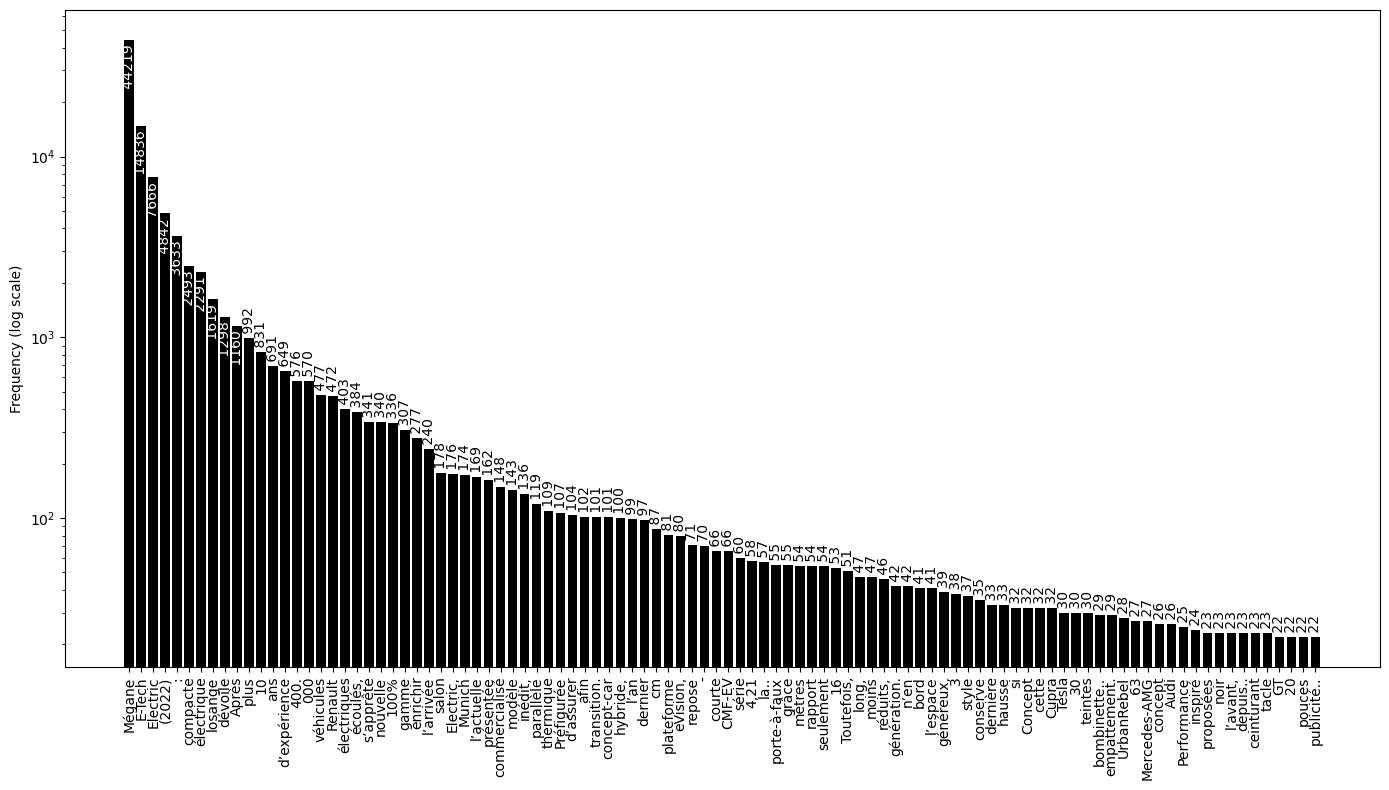

<Figure size 432x288 with 0 Axes>

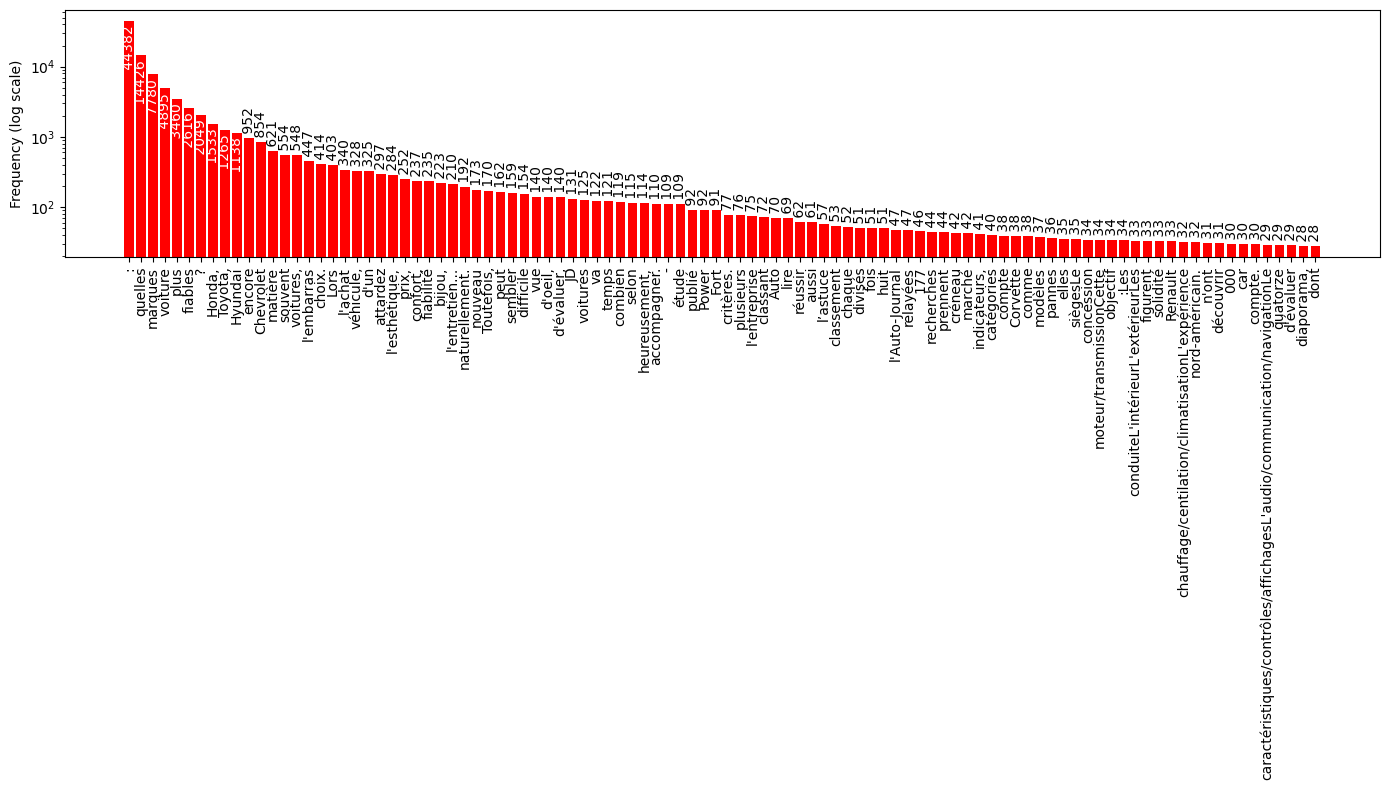

In [12]:
df_audi = df[df.text.str.contains(r"\b(?:audi)\b", case=False)]
df_audi = df_audi.loc[df_audi['Country'] == "France"]

words_audi = df_audi["clean_text_aux"].tolist()
list_of_lists_audi =[]
for i in words_audi: list_of_lists_audi.append(i.split(" "))
words_audi = [item for sublist in list_of_lists_audi for item in sublist]
list_of_lists =[]
for i in words_audi: list_of_lists.append(i.split(" "))
flat_list = [item for sublist in list_of_lists for item in sublist]
list_words = [w for w in flat_list if not w.lower() in stopwords]


#Counter(list_words).most_common(100)
from matplotlib import pyplot as plt
indices = np.random.zipf(1.6, size=100000).astype(int) % len(list_words)
articles = np.array(list_words)[indices]
tf = Counter(articles)
plt.figure().suptitle('AUDI 100 MOST COMMON WORDS')
plt.figure(figsize=(14, 8), dpi=100)

y = [count for tag, count in tf.most_common(100)]
x = [tag for tag, count in tf.most_common(100)]
plt.bar(x, y, color='black')
plt.ylabel("Frequency (log scale)")
plt.yscale('log') # optionally set a log scale for the y-axis
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(100)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')

plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()


#df_toyota = df.query('clean_text_aux.str.contains("toyota")', engine='python')
df_toyota = df[df.text.str.contains(r"\b(?:toyota)\b", case=False)]
df_toyota = df_toyota.loc[df_toyota['Country'] == "France"]

words_toyota = df_toyota["clean_text_aux"].tolist()
list_of_lists_toyota =[]
for i in words_toyota: list_of_lists_toyota.append(i.split(" "))
words_toyota = [item for sublist in list_of_lists_toyota for item in sublist]
list_of_lists =[]
for i in words_toyota: list_of_lists.append(i.split(" "))
flat_list = [item for sublist in list_of_lists for item in sublist]
list_words = [w for w in flat_list if not w.lower() in stopwords]
#Counter(list_words).most_common(100)
from matplotlib import pyplot as plt
indices = np.random.zipf(1.6, size=100000).astype(int) % len(list_words)
articles = np.array(list_words)[indices]
tf = Counter(articles)
plt.figure().suptitle('TOYOTA 50 MOST COMMON WORDS')
plt.figure(figsize=(14, 8), dpi=100)
y = [count for tag, count in tf.most_common(100)]
x = [tag for tag, count in tf.most_common(100)]
plt.bar(x, y, color='red')
plt.ylabel("Frequency (log scale)")
plt.yscale('log') # optionally set a log scale for the y-axis
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(100)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')

plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

##### France Network:
The most common words in Audi are: 
- Mégane
- E-Tech
- Electric
- compacte
- électrique
- expérience
- nouvelle
- modèle
- inédit
- hybride
- concept-car
- Audi
- Tesla
- performance
- Mercedes-AMG
- Cupra
- ...
    ###### 💡AUDI FRANCE: ELECTRIC CONCEPT, LIFESTYLE // MEGANE, TESLA, MERCEDES AMG AND CUPRA
    
    
The most common words in Toyota are: 
- fiables
- Honda
- Toyota
- Hyundai
- Chevrolet
- matiere
- choix
- prix
- confort
- power accompagner
- lire
- Renault
- Peugeot
- solidité

    ###### 💡TOYOTA FRANCE: FEATURES AND CHARACTERISTICS // HONDA, TOYOTA, HYUNDAI, CHEVROLET, RENAULT AND PEUGEOT

<Figure size 432x288 with 0 Axes>

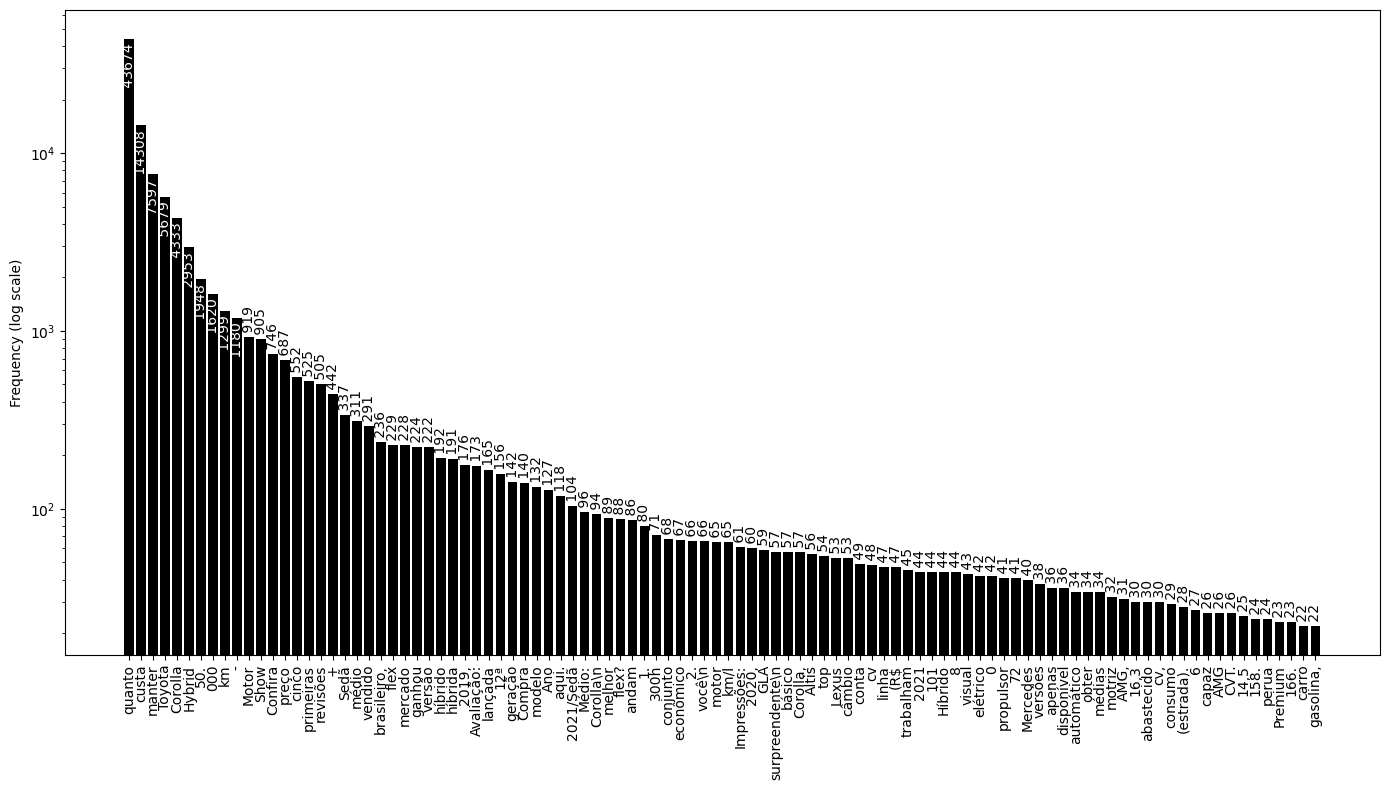

<Figure size 432x288 with 0 Axes>

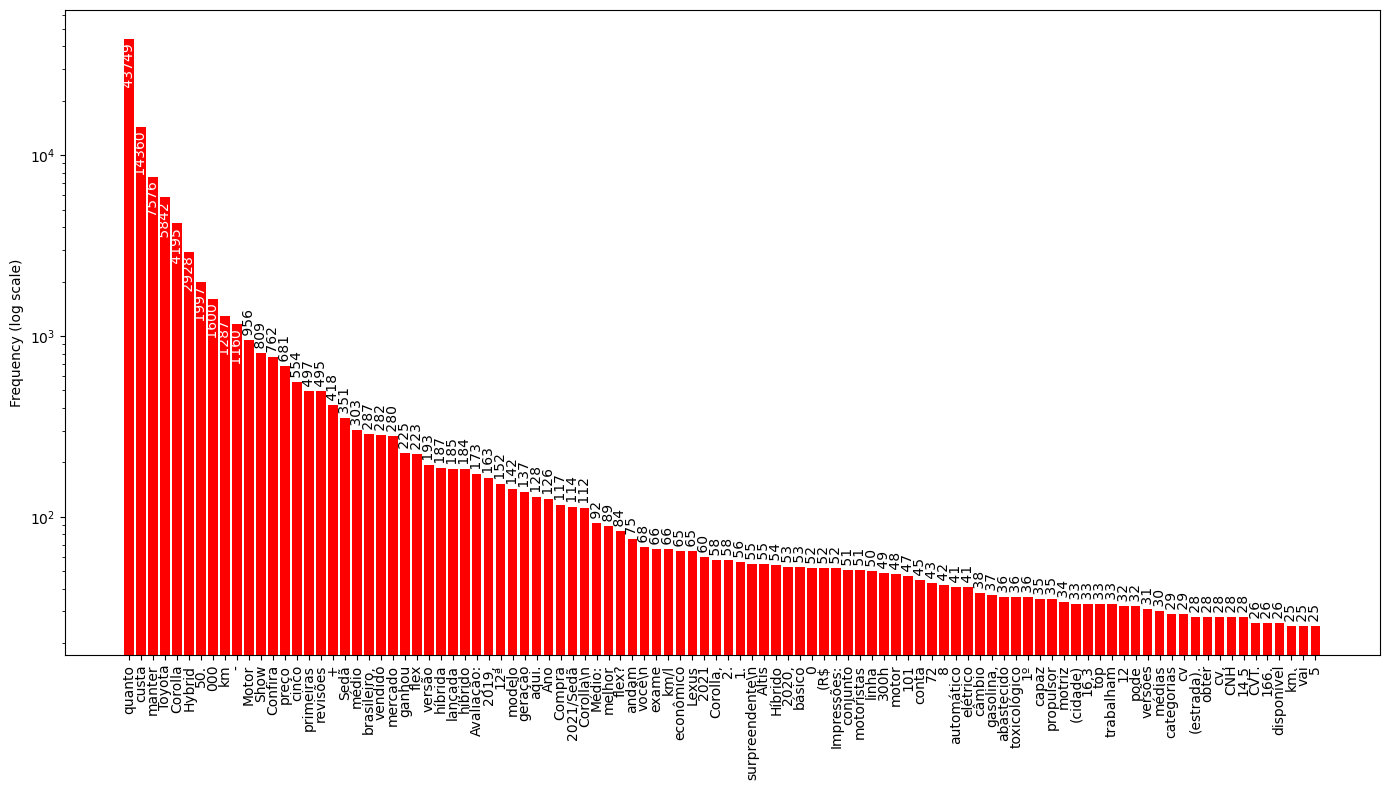

In [13]:
df_audi_orig = df[df.text.str.contains(r"\b(?:audi)\b", case=False)]
df_audi = df_audi_orig.loc[df_audi_orig['Country'] == "Brasil"]

words_audi = df_audi["clean_text_aux"].tolist()
list_of_lists_audi =[]
for i in words_audi: list_of_lists_audi.append(i.split(" "))
words_audi = [item for sublist in list_of_lists_audi for item in sublist]
list_of_lists =[]
for i in words_audi: list_of_lists.append(i.split(" "))
flat_list = [item for sublist in list_of_lists for item in sublist]
list_words = [w for w in flat_list if not w.lower() in stopwords]


#Counter(list_words).most_common(100)
from matplotlib import pyplot as plt
indices = np.random.zipf(1.6, size=100000).astype(int) % len(list_words)
articles = np.array(list_words)[indices]
tf = Counter(articles)
plt.figure().suptitle('AUDI 100 MOST COMMON WORDS')
plt.figure(figsize=(14, 8), dpi=100)

y = [count for tag, count in tf.most_common(100)]
x = [tag for tag, count in tf.most_common(100)]
plt.bar(x, y, color='black')
plt.ylabel("Frequency (log scale)")
plt.yscale('log') # optionally set a log scale for the y-axis
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(100)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')

plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()


#df_toyota = df.query('clean_text_aux.str.contains("toyota")', engine='python')
df_toyota_orig = df[df.text.str.contains(r"\b(?:toyota)\b", case=False)]
df_toyota = df_toyota_orig.loc[df_toyota_orig['Country'] == "Brasil"]

words_toyota = df_toyota["clean_text_aux"].tolist()
list_of_lists_toyota =[]
for i in words_toyota: list_of_lists_toyota.append(i.split(" "))
words_toyota = [item for sublist in list_of_lists_toyota for item in sublist]
list_of_lists =[]
for i in words_toyota: list_of_lists.append(i.split(" "))
flat_list = [item for sublist in list_of_lists for item in sublist]
list_words = [w for w in flat_list if not w.lower() in stopwords]
#Counter(list_words).most_common(100)
from matplotlib import pyplot as plt
indices = np.random.zipf(1.6, size=100000).astype(int) % len(list_words)
articles = np.array(list_words)[indices]
tf = Counter(articles)
plt.figure().suptitle('TOYOTA 50 MOST COMMON WORDS')
plt.figure(figsize=(14, 8), dpi=100)
y = [count for tag, count in tf.most_common(100)]
x = [tag for tag, count in tf.most_common(100)]
plt.bar(x, y, color='red')
plt.ylabel("Frequency (log scale)")
plt.yscale('log') # optionally set a log scale for the y-axis
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(100)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')

plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

##### Brasil Network:
The most common words in Audi are: 
- quanto custa
- Toyota Corolla
- hybrid
- precio
- mercado
- vendido
- Lexus
- Mercedes
- Híbrido
- concept-car
- Audi
- Tesla
- performance
- Mercedes-AMG
- Cupra
- ...
    ###### 💡AUDI BRASIL: HYBRID AND PRICE // TOYOTA COROLLA, LEXUS AND TESLA
    
    
The most common words in Toyota are: 
- quanto custa manter
- Toyota Corolla
- Motor
- avaliacao
- basico
- economico
- Lexus
- impressoes
- gasolina
- automático
- propulsor
- medias
- motriz

    ###### 💡TOYOTA BRASIL: FUNCIONALITY AND PRICE // TOYOTA COROLLA AND LEXUS, HYUNDAI

# 3. Open content questions

### 3.1 We have a campaign in Spain focused on automotive, which are the more relevant keywords for these types of campaigns?

<Figure size 432x288 with 0 Axes>

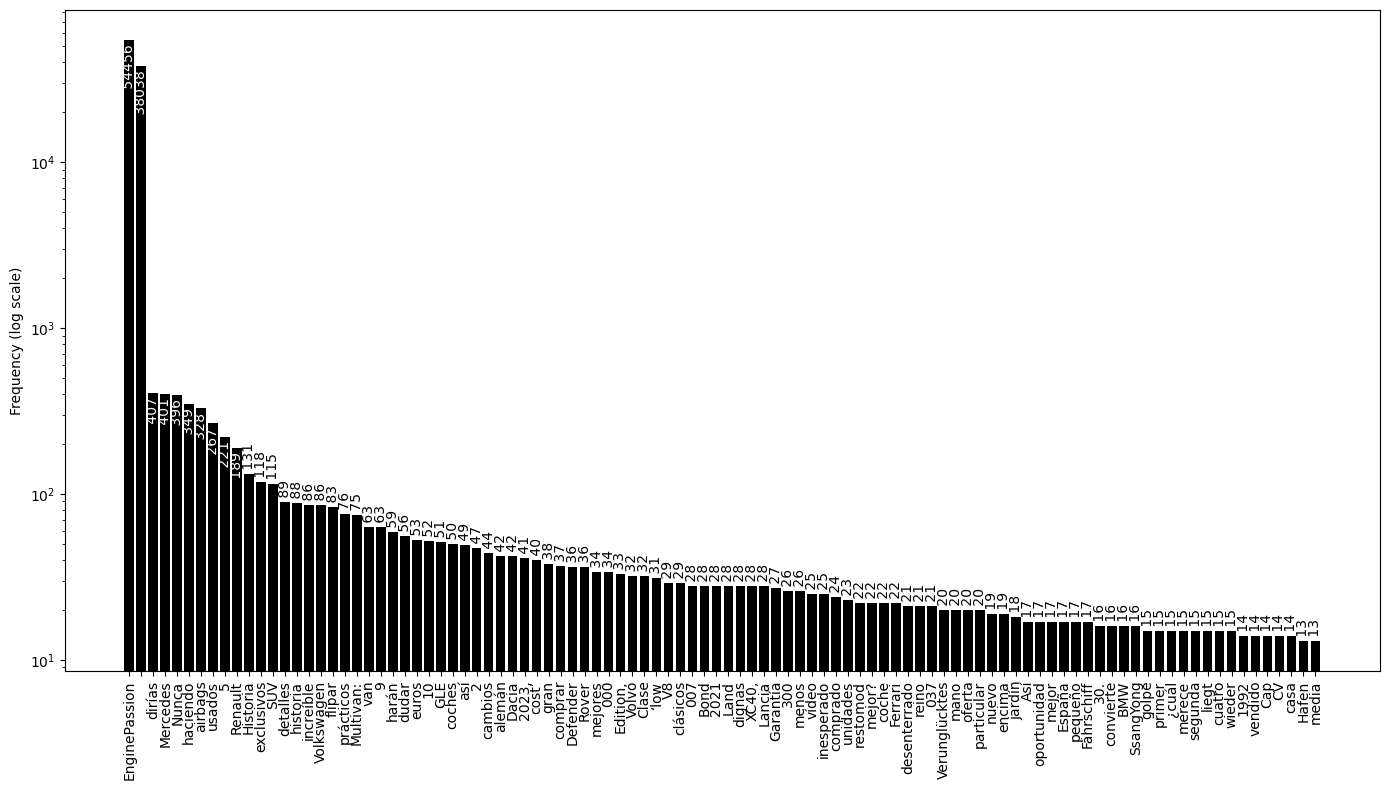

In [14]:
df_spain_automotive = df_es.loc[df_es['pageSubcategory'] == "automotive"]
words_sp_auto = df_spain_automotive["title"].tolist()
list_of_lists_sp_auto =[]
for i in words_sp_auto: list_of_lists_sp_auto.append(i.split(" "))
words_sp_auto = [item for sublist in list_of_lists_sp_auto for item in sublist]
list_of_lists =[]
for i in words_sp_auto: list_of_lists.append(i.split(" "))
flat_list = [item for sublist in list_of_lists for item in sublist]
list_words = [w for w in flat_list if not w.lower() in stopwords]
from matplotlib import pyplot as plt
indices = np.random.zipf(1.6, size=100000).astype(int) % len(list_words)
articles = np.array(list_words)[indices]
tf = Counter(articles)
plt.figure().suptitle('SPAIN AUTOMOTIVE 100 MOST COMMON WORDS')
plt.figure(figsize=(14, 8), dpi=100)
y = [count for tag, count in tf.most_common(100)]
x = [tag for tag, count in tf.most_common(100)]
plt.bar(x, y, color='black')
plt.ylabel("Frequency (log scale)")
plt.yscale('log') # optionally set a log scale for the y-axis
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(100)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()


The more relevant keywords in title for automotive campaigns in Spain are: 
- Mercedes
- airbags
- usados
- Renault
- SUV
- Multivan
- Volkswagen
- flipar
- dudar
- prácticos
- mejores
- 10
- Dacia
- aleman
- Rover
- euros
- comprar
- Volvo
- mejor
- nuevo
- segunda mano
- BMW
- superdeportivo
- Ferrari
- Ford
- Kia
- baratos
- Peugeot
- Cabrio

#### 💡These keywords indicate that price (usados, euros, segunda mano, baratos, ...) and opinions (mejores 10, mejor, prácticos, ...) are relevant in Spain

### 3.2 Try to find similarities between two or more categories

In [15]:
aux3 = df.groupby(['pageCategory', 'pageBrandsafe']).agg({'ClientAdImpression':'sum'})
aux4 = df.groupby(['pageCategory', 'pageBrandsafe']).agg({'ClientAdView1s50':'sum'})
aux_3_2_1 = aux3.merge(aux4, on=['pageCategory','pageBrandsafe'], how='left', indicator=False)
aux_3_2_1['Pct'] = 100*(aux_3_2_1['ClientAdView1s50']/aux_3_2_1['ClientAdImpression'])
aux_3_2_1 = aux_3_2_1['Pct'].unstack(level=1)
aux_3_2_1.iplot(kind='bar', color=['deepskyblue','springgreen','magenta','yellow'],
    xTitle='Category', yTitle='Pct ClientAdView1s50/ClientAdImpression',
    title= 'Category in terms of ClientAdView1s50 / ClientAdImpression')

#### Visualization time in Display Ads:

###### 💡 Signalling categories such as Style and Autos have similarities in terms of  in terms of % AdView1s50 / AdImpression
###### 💡 Developing categories such as Environment and Tech have similarities in terms of % AdView1s50 / AdImpression

In [16]:
aux3 = df.groupby(['pageCategory', 'pageBrandsafe']).agg({'ClientAdImpression':'sum'})
aux4 = df.groupby(['pageCategory', 'pageBrandsafe']).agg({'ClientAdView2s50':'sum'})
aux_3_2_1 = aux3.merge(aux4, on=['pageCategory','pageBrandsafe'], how='left', indicator=False)
aux_3_2_1['Pct'] = 100*(aux_3_2_1['ClientAdView2s50']/aux_3_2_1['ClientAdImpression'])
aux_3_2_1 = aux_3_2_1['Pct'].unstack(level=1)
aux_3_2_1.iplot(kind='bar', color=['deepskyblue','springgreen','magenta','yellow'],
    xTitle='Category', yTitle='Pct ClientAdView2s50/ClientAdImpression',
    title= 'Category in terms of ClientAdView2s50 / ClientAdImpression')

#### Visualization time in Video Ads

###### 💡 Signalling categories such as Style and Autos have similarities in terms of % AdView2s50 / AdImpression
###### 💡 Developing categories such as Environment and Tech have similarities in terms of % AdView2s50 / AdImpression

### 3.3 Who is the most relevant personality (actor, sportsman, politician, etc.) in each country?

In [17]:
import spacy
import pandas as pd
from nltk.corpus import webtext
import collections
nlp = spacy.load("en_core_web_sm")

In [118]:
nlp = spacy.load("en_core_web_sm")
nlp.max_lenght = 22380000
df_gb_names = df_gb[['text']].sample(50)
estring = df_gb_names['text'].tolist()
estring = ' '.join(estring)
doc = nlp (estring)
a = []
for ent in doc.ents:
    if ent.label_ == 'PERSON':
        a = a+[ent.text]
Counter1 = collections.Counter(a)
most_occur = Counter1.most_common(10)
most_occur = pd.DataFrame (most_occur, columns = ['word','frequency'])
most_occur.iplot(kind='bar',color='white',x='word',y='frequency')

In [119]:
nlp = spacy.load("en_core_web_sm")
nlp.max_lenght = 16370000
df_es_names = df_es[['text']].sample(50)
estring = df_es_names['text'].tolist()
estring = ' '.join(estring)
doc = nlp (estring)
a = []
for ent in doc.ents:
    if ent.label_ == 'PERSON':
        a = a+[ent.text]
Counter2 = collections.Counter(a)
most_occur = Counter2.most_common(15)
most_occur = pd.DataFrame (most_occur, columns = ['word','frequency'])
most_occur.iplot(kind='bar',color='red',x='word',y='frequency',title='Spain')

In [120]:
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 7840000
df_fr_names = df_fr[['text']].sample(50)
estring = df_fr_names['text'].tolist()
estring = ' '.join(estring)
doc = nlp (estring)
a = []
for ent in doc.ents:
    if ent.label_ == 'PERSON':
        a = a+[ent.text]
Counter3 = collections.Counter(a)
most_occur = Counter3.most_common(15)
most_occur = pd.DataFrame (most_occur, columns = ['word','frequency'])
most_occur.iplot(kind='bar',color='blue',x='word',y='frequency',title='France')

In [121]:
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 5330000
df_br_names = df_br[['text']].sample(50)
estring = df_br_names['text'].tolist()
estring = ' '.join(estring)
doc = nlp (estring)
a = []
for ent in doc.ents:
    if ent.label_ == 'PERSON':
        a = a+[ent.text]
Counter4 = collections.Counter(a)
most_occur = Counter4.most_common(15)
most_occur = pd.DataFrame (most_occur, columns = ['word','frequency'])
most_occur.iplot(kind='bar',color='yellow',x='word',y='frequency',title='Brazil')

In [115]:

def merge_vocabs(*vocabs):
    merged = spacy.vocab.Vocab()
    # Inherit some attributes from the first vocab
    # This assumes they are the same across vocabs
    merged.lex_attr_getters = vocabs[0].lex_attr_getters
    merged.morphology = vocabs[0].morphology
    merged.lookups = vocabs[0].lookups
    merged.lookups_extra = vocabs[0].lookups_extra
    # Copy strings and vectors from all vocabs to merged
    for vocab in vocabs:
        for string in vocab.strings:
            string_id = merged.strings.add(string)
            try:
                # Copy vector if exists
                vector = vocab.vectors[string_id]
                merged.set_vector(string_id, vector)
            except KeyError:
                pass
    return merged


nlp = spacy.load("en_core_web_sm")
nlp.max_length = 5330000
df_br_names = df_br[['text']].sample(2)
list_of_text = df_br_names['text'].tolist()


doc_iter = nlp("")
doc_f = nlp("")
doc_f_2 = nlp("")
union_docs_2 = nlp ("")

for item in list_of_text:
    
    merge_vocabs(str(union_docs_2), str(union_docs))
    list_of_docs_2 = [union_docs_2, union_docs]
    union_docs_2 = Doc.from_docs(list(nlp.pipe(list_of_docs_2)))
    
    for line in item.split(','):
        doc_iter = nlp(''.join(ch for ch in line if ch.isalnum() or ch == " "))
        list_of_docs = [doc_f, doc_iter]
        union_docs = Doc.from_docs(list(nlp.pipe(list_of_docs)))

union_docs_2



            



AttributeError: 'str' object has no attribute 'lex_attr_getters'